# Hyperparameter optimisation blueprint

Join us as we explore the blueprint for hyperparameter optimization in machine learning. This talk covers tools like TensorFlow and Optuna, thorough preparatory steps including data handling and baseline modeling, and approaches from grid search to Bayesian optimization. Learn to effectively utilize algorithms such as Gaussian Processes and Tree-structured Parzen Estimators to fine-tune your models, enhancing performance and ensuring robustness. Perfect for ML professionals aiming to master their model's efficiency and accuracy.

In [1]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Dataset

In [2]:
# (alternative) get some data
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True, n_class=10)
X.shape, y.shape

((1797, 64), (1797,))

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784') # load the mnist dataset
X, y = mnist.data.values, mnist.target.values
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((1257, 64), (270, 64), (270, 64))

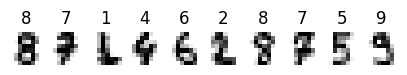

In [4]:
# plot the first 3 images using matplotlib
def plot_digits(X, y):
    num_digits = X.shape[0]
    shape = (np.sqrt(X.shape[1]).astype(int), np.sqrt(X.shape[1]).astype(int))  # assuming square images

    fig, axs = plt.subplots(1, num_digits, figsize=(5, 5))
    for i, ax in enumerate(axs):
        ax.axis('off')
        ax.imshow(X[i].reshape(*shape), cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f'{y[i]}')
    

plot_digits(X_train[:10], y_train[:10])

## Grid search

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

model = Pipeline([
    ('preprocessor', None),
    ('model',  SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True, n_jobs=-1, random_state=42))
])

model.fit(X_train, y_train)
print(model.score(X_val, y_val))

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

0.9592592592592593
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.90      1.00      0.95        26
           2       1.00      1.00      1.00        20
           3       1.00      0.90      0.95        21
           4       1.00      0.97      0.98        31
           5       0.97      0.95      0.96        39
           6       0.94      1.00      0.97        30
           7       0.96      0.96      0.96        28
           8       0.83      0.83      0.83        18
           9       0.97      0.94      0.96        35

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



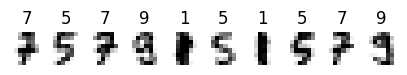

In [6]:
plot_digits(X_val[:10], y_pred[:10])

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__alpha': [1e-4, 1e-2, 1],
    'model__l1_ratio': [0, 0.1, 0.5, 1],
    'model__max_iter': [1000, 5000],
    'model__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/crist

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', None),
                                       ('model',
                                        SGDClassifier(n_jobs=-1,
                                                      penalty='elasticnet',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.0001, 0.01, 1],
                         'model__l1_ratio': [0, 0.1, 0.5, 1],
                         'model__loss': ['hinge', 'log', 'modified_huber',
                                         'squared_hinge', 'perceptron'],
                         'model__max_iter': [1000, 5000]},
             verbose=2)

In [8]:
df = pd.DataFrame(grid_search.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,param_model__loss,param_model__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085426,0.004454,0.001571,0.000150,0.0001,0,hinge,1000,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,...",0.952267,0.933174,0.937947,0.941130,0.008113,19
1,0.088156,0.016560,0.002354,0.000179,0.0001,0,hinge,5000,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,...",0.952267,0.933174,0.937947,0.941130,0.008113,19
2,0.001479,0.000309,0.000000,0.000000,0.0001,0,log,1000,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,...",NaN,NaN,NaN,NaN,NaN,97
3,0.001486,0.000245,0.000000,0.000000,0.0001,0,log,5000,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,...",NaN,NaN,NaN,NaN,NaN,97
4,0.075093,0.012958,0.006245,0.006145,0.0001,0,modified_huber,1000,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,...",0.945107,0.923628,0.930788,0.933174,0.008930,48


In [9]:
df[['mean_test_score', 'params']]

,mean_test_score,params
0,0.941130,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,..."
1,0.941130,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,..."
2,NaN,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,..."
3,NaN,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,..."
4,0.933174,"{'model__alpha': 0.0001, 'model__l1_ratio': 0,..."
...,...,...
115,0.793158,"{'model__alpha': 1, 'model__l1_ratio': 1, 'mod..."
116,0.909308,"{'model__alpha': 1, 'model__l1_ratio': 1, 'mod..."
117,0.910103,"{'model__alpha': 1, 'model__l1_ratio': 1, 'mod..."
118,0.254574,"{'model__alpha': 1, 'model__l1_ratio': 1, 'mod..."


In [15]:
res = pd.DataFrame.from_records(df['params'].tolist())
res['score'] = df['mean_test_score']

res.head()

,model__alpha,model__l1_ratio,model__loss,model__max_iter,score
0,0.0001,0.0,hinge,1000,0.941130
1,0.0001,0.0,hinge,5000,0.941130
2,0.0001,0.0,log,1000,NaN
3,0.0001,0.0,log,5000,NaN
4,0.0001,0.0,modified_huber,1000,0.933174


## Visualizing the results

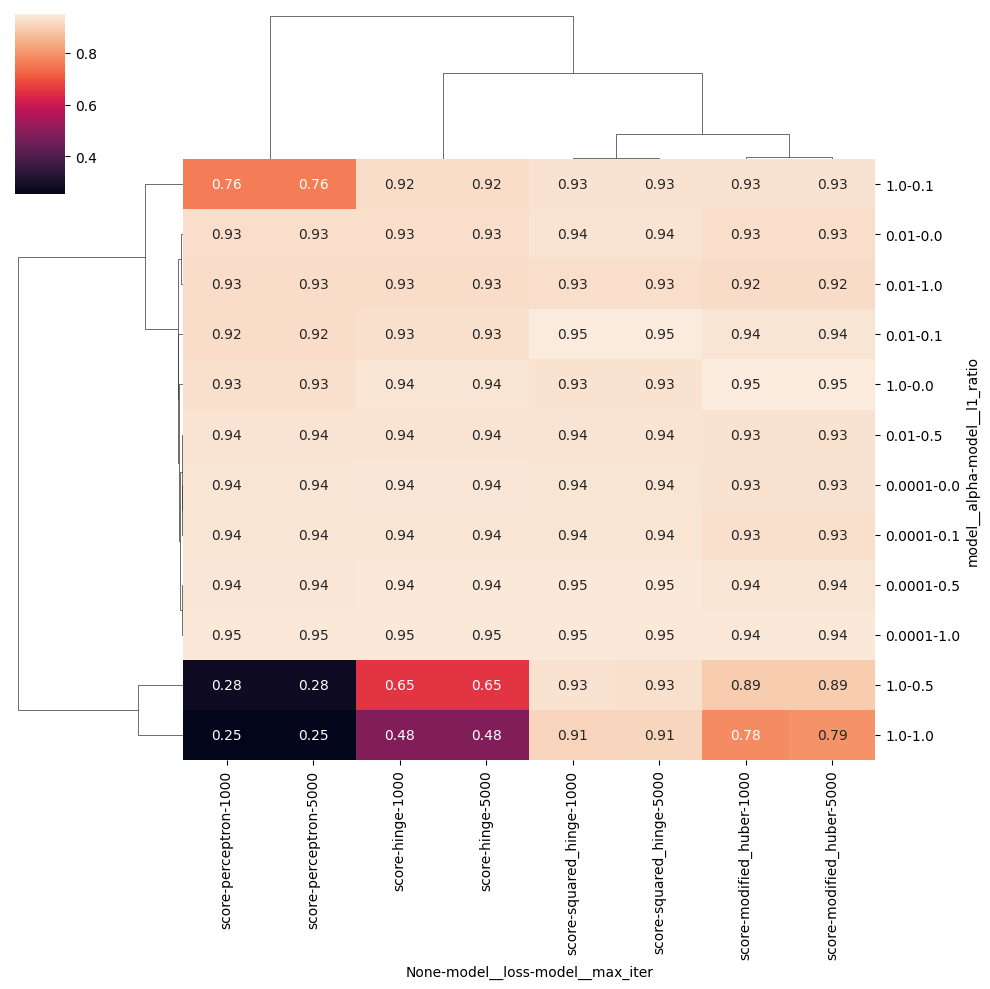

In [20]:
import seaborn as sns

sns.clustermap(res.pivot_table(
    values=['score'], 
    index=['model__alpha', 'model__l1_ratio'],     # df.columns[:len(df.columns)//2]
    columns=['model__loss', 'model__max_iter']                  # df.columns[len(df.columns)//2:]         
), annot=True)


In [21]:
grid_search.best_params_

{'model__alpha': 0.01,
 'model__l1_ratio': 0.1,
 'model__loss': 'squared_hinge',
 'model__max_iter': 1000}

```python
from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm

grid_search = {
        # model config
        "add_bias": [True, False],
        "dropout": [0.1, 0.8],
        "embedding_size": [8, 16],
        "lr": [0.001, 0.00001],
        
        # training procedure
        "batch_size": [50, 200],
        "shuffle": [True, False],
        "optimizer": [RMSprop, SGD]
}
        
repeats = 5
write_header()
for group, config in enumerate(tqdm(ParameterGrid(grid_search))):
    for _ in range(repeats):
        model = build_model_from_config(**config)
        history = train_from_config(model, **config)
        stats = compute_stats(history)
        write_stats(stats)
```

## Random search

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__alpha': [1e-4, 1e-2, 1],
    'model__l1_ratio': [0, 0.1, 0.5, 1],
    'model__max_iter': [1000, 5000],
    'model__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/cristi/Envs/nanoGPT/lib/python3.9/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt,

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor', None),
                                             ('model',
                                              SGDClassifier(n_jobs=-1,
                                                            penalty='elasticnet',
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__alpha': [0.0001, 0.01, 1],
                                        'model__l1_ratio': [0, 0.1, 0.5, 1],
                                        'model__loss': ['hinge', 'log',
                                                        'modified_huber',
                                                        'squared_hinge',
                                                        'perceptron'],
                                        'model__max_iter': [1000, 5000]},
                   verbose=2)

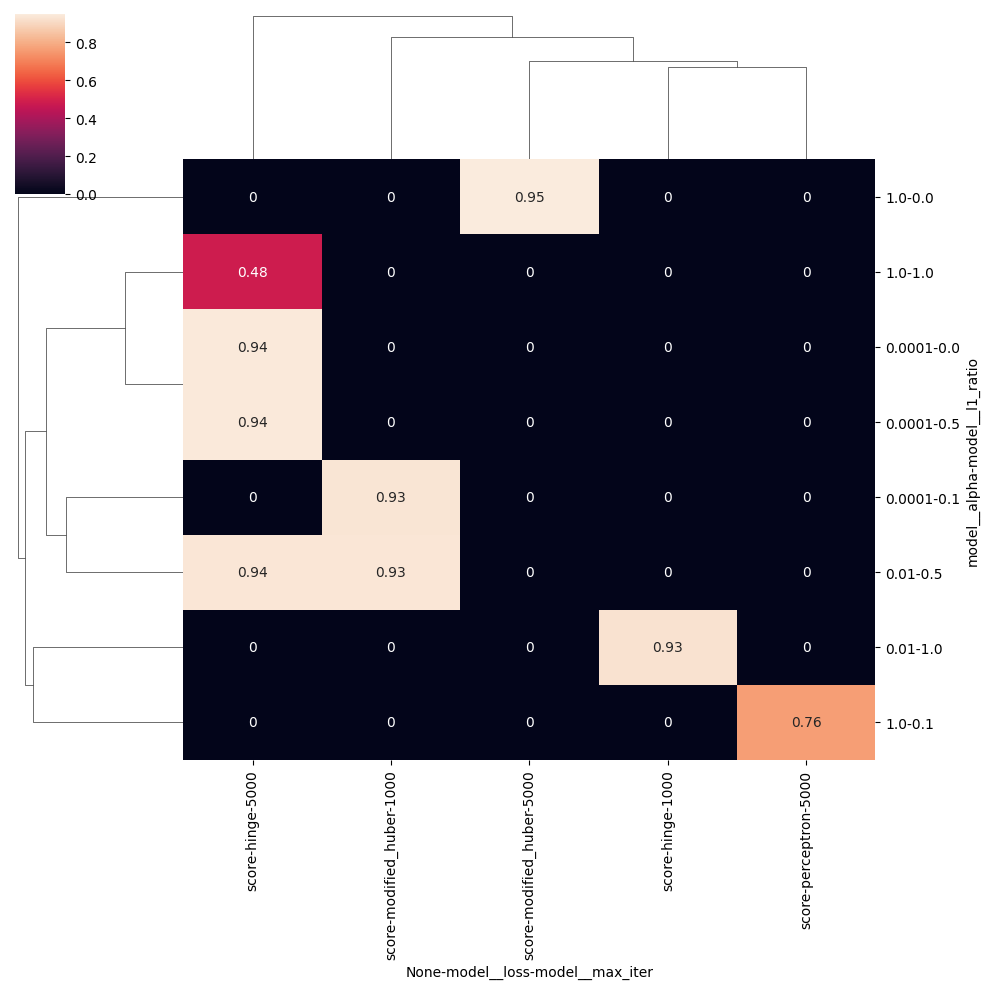

In [28]:
import seaborn as sns

df = pd.DataFrame(random_search.cv_results_)
res = pd.DataFrame.from_records(df['params'].tolist())
res['score'] = df['mean_test_score']

sns.clustermap(res.pivot_table(
    values=['score'], 
    index=['model__alpha', 'model__l1_ratio'],     # df.columns[:len(df.columns)//2]
    columns=['model__loss', 'model__max_iter']                  # df.columns[len(df.columns)//2:]         
).fillna(0), annot=True)

## Halving grid search

In [32]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples=4000, n_features=12)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((2800, 12), (600, 12), (600, 12))

In [40]:
np.random.randint(1, 6, 10)

array([3, 1, 4, 2, 1, 4, 2, 5, 2, 5])

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

model = RandomForestClassifier(n_estimators=20)

param_grid = {
    "max_depth": [3, None],
    "max_features": np.random.randint(1, 6, 3),
    "min_samples_split": np.random.randint(2, 11, 3),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}
rsh = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, factor=2
)
rsh.fit(X_train, y_train)

HalvingGridSearchCV(estimator=RandomForestClassifier(n_estimators=20), factor=2,
                    param_grid={'bootstrap': [True, False],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': [3, None],
                                'max_features': array([4, 5, 3]),
                                'min_samples_split': array([5, 6, 6])})

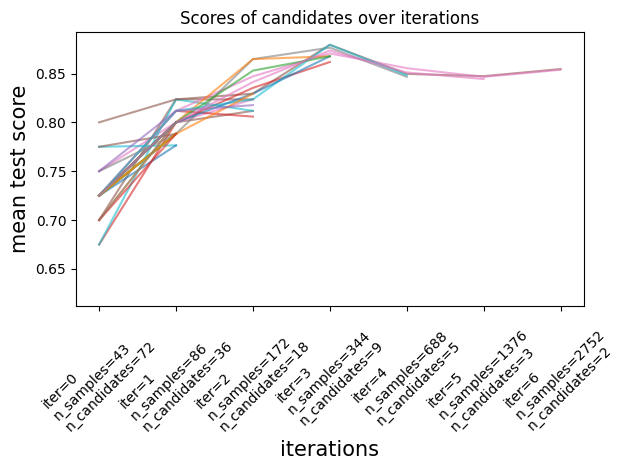

In [43]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [44]:
rsh.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 3,
 'min_samples_split': 6}

In [55]:
rsh.best_score_

0.8545454545454545

## FLAML

[FLAML](https://microsoft.github.io/FLAML/docs/getting-started)

Automatically searches all possible hiperparameters and models.
* It uses custom objects (flaml internal)
* It defines built-in search spaces for each type of model
* Runs on a predefined time budget

https://www.microsoft.com/en-us/research/uploads/prod/2021/03/MLSys21FLAML.pdf



In [53]:
from flaml import AutoML
# from flaml.automl.model import RandomForestEstimator

automl = AutoML()
automl.add_learner('rf', RandomForestEstimator)

settings = {
    "time_budget": 180,  # total running time in seconds
    # "metric": custom_metric,
    "metric": 'accuracy',
    "estimator_list": ['rf'],
    "task": 'classification',  # task type
    "log_file_name": 'flaml_experiment.log',  # flaml log file
    "X_val": X_val,
    "y_val": y_val,
    "verbose": 10,
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

print('Best hyper-parmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1 - automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

[flaml.automl.logger: 05-29 16:13:58] {1680} INFO - task = classification
[flaml.automl.logger: 05-29 16:13:58] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 05-29 16:13:58] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-29 16:13:58] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 05-29 16:13:58] {1901} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 05-29 16:13:58] {2219} INFO - iteration 0, current learner rf
[flaml.tune.tune: 05-29 16:13:58] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.2886751345948129, 'max_leaves': 4, 'criterion': 'entropy'}
[flaml.tune.tune: 05-29 16:13:58] {202} INFO - result: {'pred_time': 2.424796422322591e-05, 'wall_clock_time': 0.058934926986694336, 'metric_for_logging': {'pred_time': 2.424796422322591e-05}, 'val_loss': 0.15166666666666662, 'trained_estimator': <flaml.automl.model.RandomForestEstimator object at 0x15a81afa0>, 'training_iteration': 0, '

In [54]:
automl.model.estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.46544962017277147,
 'max_leaf_nodes': 29,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 42,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 12032022,
 'verbose': 0,
 'warm_start': False}

You can transplanf the best model to a scikit-learn model

For custom estimators you need to define a custom search space

```python
from flaml.automl.model import SKLearnEstimator
# SKLearnEstimator is derived from BaseEstimator
import rgf


class MyRegularizedGreedyForest(SKLearnEstimator):
    def __init__(self, task="binary", **config):
        super().__init__(task, **config)

        if task in CLASSIFICATION:
        from rgf.sklearn import RGFClassifier

        self.estimator_class = RGFClassifier
        else:
        from rgf.sklearn import RGFRegressor

        self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        space = {
        "max_leaf": {
            "domain": tune.lograndint(lower=4, upper=data_size),
            "low_cost_init_value": 4,
        },
        "n_iter": {
            "domain": tune.lograndint(lower=1, upper=data_size),
            "low_cost_init_value": 1,
        },
        "learning_rate": {"domain": tune.loguniform(lower=0.01, upper=20.0)},
        "min_samples_leaf": {
            "domain": tune.lograndint(lower=1, upper=20),
            "init_value": 20,
        },
        }
        return space
```

## Bayesian optimization

Bayesian Optimization builds a probability model of the objective function and uses it to select hyperparameter to evaluate in the true objective function.
Uses Gaussian Processes and Tree-structured Parzen Estimators for finding the next best hyperparameter.
> Prezen-Trees are a type of decision tree that uses a kernel density estimator to estimate the probability density function of the target variable.

Probably better explained [here](https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f)  


In [57]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.5 MB/s eta 0:00:001.5 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [60]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20)

param_grid = {
    'bootstrap': Categorical([True, False]),
    'max_depth': Integer(10, 100),
    'max_features': Integer(1, 10),
    'min_samples_leaf': Integer(1, 10),
    'min_samples_split': Integer(2, 10),
    'n_estimators': Integer(10, 100),
    'max_leaf_nodes': Integer(10, 100),
    'min_impurity_decrease': Real(0.0, 0.1),
    'criterion': Categorical(['gini', 'entropy']),
    'min_weight_fraction_leaf': Real(0.0, 0.5),
}
    
bayes_search = BayesSearchCV(model, param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=2)
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=20),
              n_iter=10, n_jobs=-1,
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=1, high=10, prior='u...
                             'min_impurity_decrease': Real(low=0.0, high=0.1, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_weight_fraction_leaf': Real(low=0.0, high=0.5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')},
              verbose=2)

In [61]:
bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('criterion', 'entropy'),
             ('max_depth', 56),
             ('max_features', 10),
             ('max_leaf_nodes', 11),
             ('min_impurity_decrease', 0.003857650561732885),
             ('min_samples_leaf', 6),
             ('min_samples_split', 6),
             ('min_weight_fraction_leaf', 0.4982528167190249),
             ('n_estimators', 22)])

In [62]:
bayes_search.best_score_

0.8571384855251915

<Axes: >

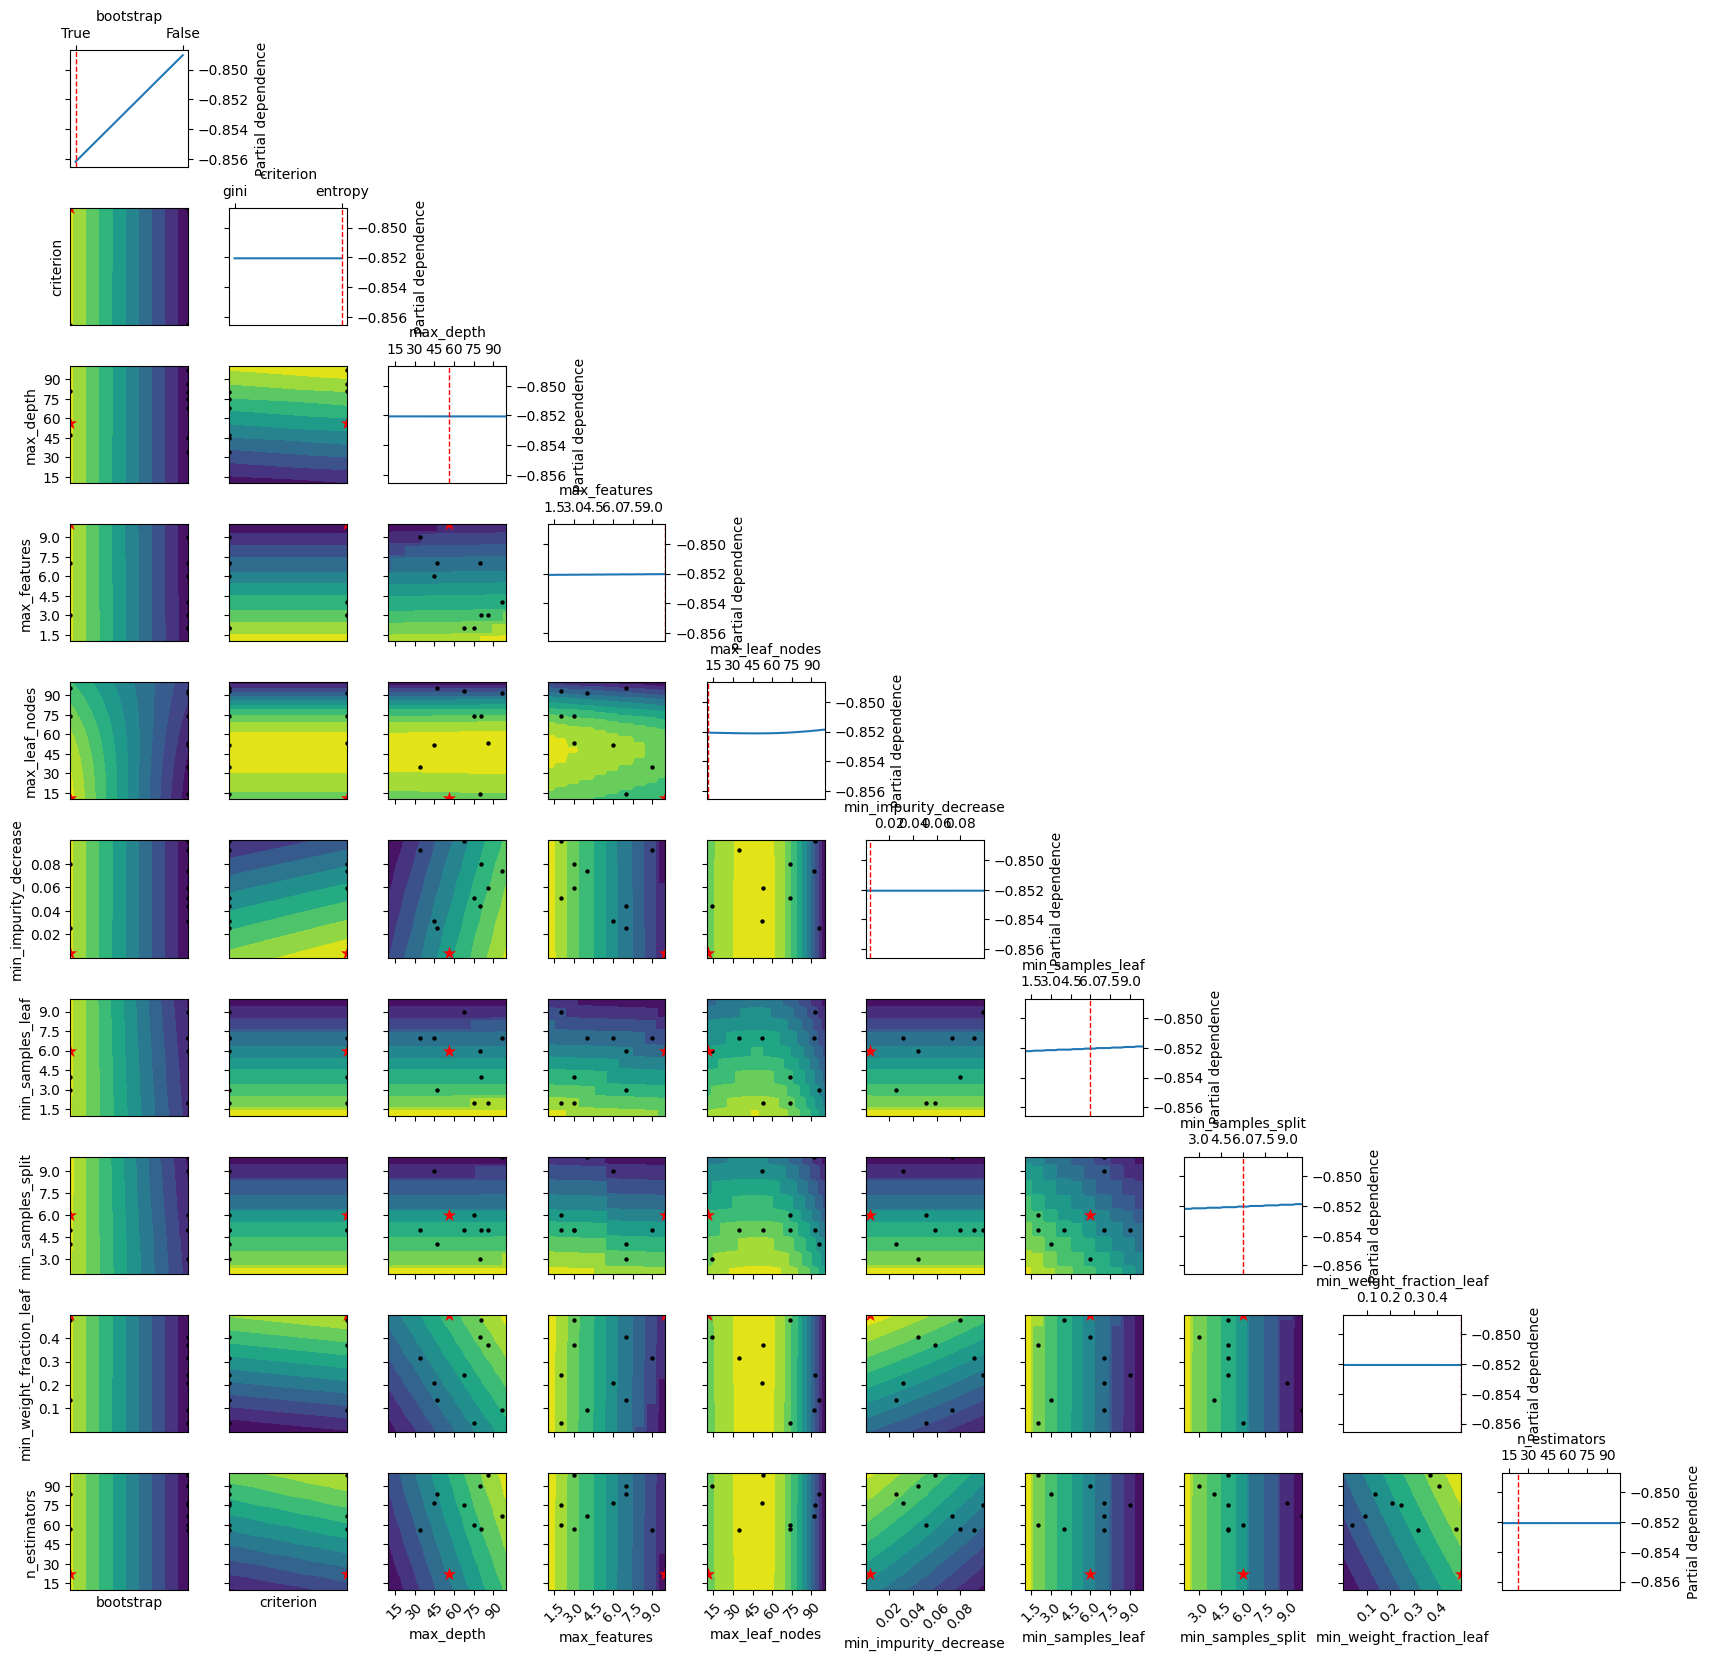

In [63]:
from skopt.plots import plot_objective
plot_objective(bayes_search.optimizer_results_[0])

## HEBO

HEBO: Heteroscedastic Evolutionary Bayesian Optimisation

In [ ]:
!pip install hebo

Bayesian optimsation library developed by Huawei Noahs Ark Decision Making and Reasoning (DMnR) lab. The winning submission to the NeurIPS 2020 Black-Box Optimisation Challenge.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from hebo.sklearn_tuner import sklearn_tuner

space_cfg = [
    {'name' : 'max_depth', 'type' : 'int', 'lb' : 1, 'ub' : 20},
    {'name' : 'min_samples_leaf', 'type' : 'num', 'lb' : 1e-4, 'ub' : 0.5},
    {'name' : 'max_features', 'type' : 'cat', 'categories' : ['auto', 'sqrt', 'log2']},
    {'name' : 'bootstrap', 'type' : 'bool'},
    {'name' : 'min_impurity_decrease', 'type' : 'pow', 'lb' : 1e-4, 'ub' : 1.0},
    ]

result = sklearn_tuner(RandomForestRegressor, space_cfg, X_train, y_train, metric = r2_score, max_iter = 16)